In [1]:
import pandas as pd
import textdistance
import re
import scipy.stats as stats
import matplotlib.pyplot as plt
from itertools import combinations

#    Experiments:

#    1 - no prompt typewriter
#    2 - no prompt all
#    3 - prompt typewriter
#    4 - prompt all
###

In [2]:
#### Takes in a dataset of repeated measures and does the stats on the selected columns
def statprint(df, keylist):
    #descriptive statistics
    print("C", "Mean", "Std")
    for k in keylist: 
        print(k, stats.tmean(df[k]), stats.tstd(df[k]))
    print("-----------")
    
    normalities = {}
    allnormal = True

    sets = []
    for k in keylist:
        sets.append(df[k])
    
    for k in keylist:
        normalities[k] = stats.normaltest(df[k]).pvalue
        if normalities[k] < 0.05:
            allnormal=False
        #print(stats.normaltest(testdf[k])) #normal p>0.05
    
    #anova or friedman?
    if allnormal:
        toprint = "ANOVA "
        stat = stats.f_oneway(*sets)
    else:
        toprint = "FRIEDMAN "
        stat = stats.friedmanchisquare(*sets)
        
    print(toprint+str(round(stat.statistic, 4)) + ", p="+str(round(stat.pvalue,4)))
    print("-----------")
    
    if stat.pvalue<0.05: # go to paired tests
    
        #paired sample tests
        
        combos = list(combinations(keylist, 2))
        padj = 0.05/len(combos)
        
        for combo in combos:
            if normalities[combo[0]]>0.05 and normalities[combo[1]]>0.05:
                stat = stats.ttest_rel(df[combo[0]],df[combo[1]])
                toprint = "T-test "
            else:
                stat = stats.wilcoxon(df[combo[0]],df[combo[1]])
                toprint = "Wilcoxon "
            
            toprint += "("+str(combo[0]) +", "+ str(combo[1]) + "): "+ str(round(stat.statistic, 4)) + ", p="+str(round(stat.pvalue,4))
            
            if stat.pvalue<padj:
                toprint+=" *"
            print(toprint)
        
        print ("bf-adj p:", round(0.05/len(combos),4))
        print ('''
                #    Experiments:
                
                #    1 - no prompt typewriter
                #    2 - no prompt all
                #    3 - prompt typewriter
                #    4 - prompt all
                ''')

In [3]:
#### KEYBOARD METRICS #####

In [4]:
#### prepare the data 

In [5]:
participants = pd.read_csv('participants.csv')
events = pd.read_csv('events.csv')
phrases = pd.read_csv('phrases.csv')
participants

,pid,age,english,gender,fingers,ts
0,id0b3b44e2cef4d,24,B2,m,t,2024-07-08 12:33:10
1,id0bdef54858cd3,23,u,m,tt,2024-07-09 11:36:24
2,id15d11dd8fd8aa,23,C2,m,tt,2024-07-09 16:22:34
3,id1d7694116bf3a,28,C2,m,t,2024-07-08 16:31:07
4,id3375326df78648,33,C2,m,i,2024-07-05 14:12:00
5,id3d3533f2ad9f7,25,C1,m,tt,2024-07-08 17:47:40
6,id4800804c0a8bb,22,C2,m,tt,2024-07-09 12:33:43
7,id485d6e97579b2,25,C1,m,i,2024-07-05 14:11:46
8,id5098c7343d768,27,C1,f,tt,2024-07-05 14:23:25
9,id617cb828677308,24,C2,m,tt,2024-07-08 10:30:25


In [6]:
#find participants with incomplete phrase sets
phrases.groupby('pid').count()

,id,extype,orig_phrase,sub_phrase,effect
pid,,,,,
id0b3b44e2cef4d,40,40,40,40,40
id0bdef54858cd3,40,40,40,40,40
id15d11dd8fd8aa,40,40,40,40,40
id1d7694116bf3a,40,40,40,40,40
id3d3533f2ad9f7,40,40,40,40,40
id4800804c0a8bb,40,40,40,40,40
id485d6e97579b2,40,40,40,40,40
id88d9599e3704f,40,40,40,40,40
id95955346653c,40,40,40,40,40


In [7]:
#remove them from all data
pindex = phrases[phrases['pid']=='ida8cf5ca5e993a'].index
phrases.drop(pindex , inplace=True)
pindex = participants[participants['pid']=='ida8cf5ca5e993a'].index
participants.drop(pindex , inplace=True)
pindex = events[events['pid']=='ida8cf5ca5e993a'].index
events.drop(pindex , inplace=True)
phrases.groupby('pid').count()

,id,extype,orig_phrase,sub_phrase,effect
pid,,,,,
id0b3b44e2cef4d,40,40,40,40,40
id0bdef54858cd3,40,40,40,40,40
id15d11dd8fd8aa,40,40,40,40,40
id1d7694116bf3a,40,40,40,40,40
id3d3533f2ad9f7,40,40,40,40,40
id4800804c0a8bb,40,40,40,40,40
id485d6e97579b2,40,40,40,40,40
id88d9599e3704f,40,40,40,40,40
id95955346653c,40,40,40,40,40


In [8]:
p_participants = phrases.groupby('pid').count()
p_participants.join(participants.set_index('pid'), on='pid').groupby('english').count()

,id,extype,orig_phrase,sub_phrase,effect,age,gender,fingers,ts
english,,,,,,,,,
B2,1,1,1,1,1,1,1,1,1
C1,3,3,3,3,3,3,3,3,3
C2,8,8,8,8,8,8,8,8,8
u,1,1,1,1,1,1,1,1,1


In [9]:
phrases

,id,pid,extype,orig_phrase,sub_phrase,effect
0,1,id485d6e97579b2,4,Travis is in charge.,Trivis,0
1,2,id485d6e97579b2,4,Pressure to finish my review!,Pressure to finish your review,0
2,3,id485d6e97579b2,4,What do you think about Tracy and Jim?,What do you think about Tracy and Jim,0
3,4,id485d6e97579b2,4,He doesn't want to give the trading positions.,He doesnt want to give,0
4,5,id485d6e97579b2,4,I have forwarded to Kelly.,I have forwared to Kelly,0
...,...,...,...,...,...,...
535,541,idb53ee7b1425ce,4,Probably can handle Monday PM.,Probably can handle Monday PM.,0
536,542,idb53ee7b1425ce,4,I didn't understand we were borrowing them.,I didn't understand we were borrowing them.,0
537,543,idb53ee7b1425ce,4,I'm still here.,I'm still here.,0
538,544,idb53ee7b1425ce,4,What is up with ENE?,What is up with ENE?,0


In [10]:
def cleanstr(string):
    string = string.lower()
    string = string.strip()
    #string = ''.join(letter for letter in string if letter.isalnum())
    string = re.sub(r"[!#\"$%&'()*+,-./:;<=>?@[\]^_`{|}~]", '', string)
    return string
    
phrases['orig_clean'] = phrases['orig_phrase'].apply(cleanstr)
phrases['sub_phrase_clean'] = phrases['sub_phrase'].apply(cleanstr)
phrases['ldist']=phrases.apply(lambda x: textdistance.levenshtein.distance(x['orig_clean'], x['sub_phrase_clean']), axis=1)

phrases.groupby('extype')['ldist'].mean()

extype
1    0.961538
2    1.530769
3    1.123077
4    1.638462
Name: ldist, dtype: float64

In [11]:
# What is the MSD per condition (i.e. accuracy of submitted phrases)
ptest = phrases[['pid','extype','ldist']].groupby(['pid','extype']).mean()
ptest.reset_index(inplace=True)
ptest.head(5)

,pid,extype,ldist
0,id0b3b44e2cef4d,1,3.1
1,id0b3b44e2cef4d,2,1.9
2,id0b3b44e2cef4d,3,4.9
3,id0b3b44e2cef4d,4,5.4
4,id0bdef54858cd3,1,2.0


In [12]:
ptest=ptest.pivot(index='pid', columns ='extype', values='ldist')
ptest.reset_index(inplace=True)
ptest.head(5)

extype,pid,1,2,3,4
0,id0b3b44e2cef4d,3.1,1.9,4.9,5.4
1,id0bdef54858cd3,2.0,2.5,0.2,0.0
2,id15d11dd8fd8aa,0.0,0.0,0.2,0.3
3,id1d7694116bf3a,0.1,2.1,0.4,1.6
4,id3d3533f2ad9f7,1.1,0.9,1.0,0.0


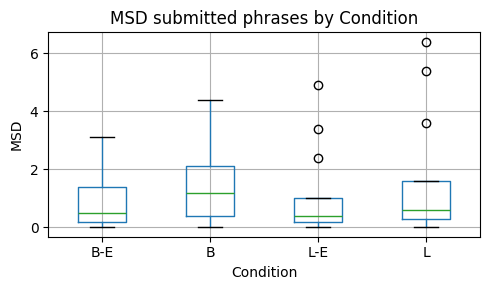

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))
#ax0, ax1, ax2, ax3 = axes.flatten()
ax0=axes
ptest.boxplot([1,2,3,4], ax=ax0)#[0])
plt.title("MSD submitted phrases by Condition")
ax0.set_xticklabels(['B-E', 'B', 'L-E', 'L'])
ax0.set_ylabel('MSD')
ax0.set_xlabel('Condition')
plt.tight_layout()
plt.show()

In [14]:
statprint(ptest, [1,2,3,4])

C Mean Std
1 0.9615384615384615 0.9836483632701793
2 1.5307692307692309 1.424420709964005
3 1.123076923076923 1.5161100697474916
4 1.6384615384615384 2.126240211240827
-----------
FRIEDMAN 2.592, p=0.4589
-----------


/Users/ako2/Documents/PythonProjects/venvs/py3.9.4/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  res = hypotest_fun_out(*samples, **kwds)


In [15]:
# MSD is not statistically significantly different across any condition

In [39]:
##### Backspace count #####

In [16]:
events.head(2)

,id,pid,phrase,event,data,itype,ts,extype,effect,tsunix
0,1,id485d6e97579b2,Travis is in charge.,KP,T,insertText,2024-07-05 14:14:02.619,4,0,1.720178e+09
1,2,id485d6e97579b2,Travis is in charge.,KP,NaN,deleteContentBackward,2024-07-05 14:14:08.379,4,0,1.720178e+09


In [17]:
events.groupby('itype').count()

,id,pid,phrase,event,data,ts,extype,effect,tsunix
itype,,,,,,,,,
deleteContentBackward,915,915,915,915,0,915,915,915,915
deleteWordBackward,3,3,3,3,0,3,3,3,3
insertText,14335,14335,14335,14335,14335,14335,14335,14335,14335


In [18]:
etest = events[events['itype']=='deleteContentBackward'][['pid','extype','id']].groupby(['pid', 'extype']).count()
etest.reset_index(inplace=True)
etest.head(5)

,pid,extype,id
0,id0b3b44e2cef4d,1,5
1,id0b3b44e2cef4d,2,8
2,id0b3b44e2cef4d,3,9
3,id0b3b44e2cef4d,4,5
4,id0bdef54858cd3,1,7


In [19]:
etest=etest.pivot(index='pid', columns ='extype', values='id')
etest.reset_index(inplace=True)
etest.head(5)

extype,pid,1,2,3,4
0,id0b3b44e2cef4d,5,8,9,5
1,id0bdef54858cd3,7,29,12,19
2,id15d11dd8fd8aa,18,17,15,25
3,id1d7694116bf3a,6,13,14,29
4,id3d3533f2ad9f7,14,35,11,12


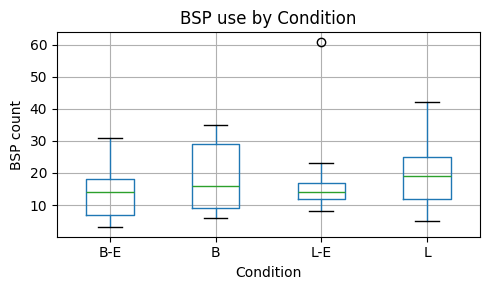

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))
#ax0, ax1, ax2, ax3 = axes.flatten()
ax0=axes
etest.boxplot([1,2,3,4], ax=ax0)#[0])
plt.title("BSP use by Condition")
ax0.set_xticklabels(['B-E', 'B', 'L-E', 'L'])

ax0.set_ylabel('BSP count')
ax0.set_xlabel('Condition')
plt.tight_layout()
plt.show()

In [21]:
statprint(etest, [1,2,3,4])

C Mean Std
1 14.23076923076923 8.4769672854727
2 18.153846153846153 10.753651735156094
3 17.846153846153847 13.53911711699446
4 20.153846153846153 9.956958654178777
-----------
FRIEDMAN 4.8898, p=0.18
-----------


/Users/ako2/Documents/PythonProjects/venvs/py3.9.4/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  res = hypotest_fun_out(*samples, **kwds)


In [22]:
# Backspace use is not statistically significantly different across any condition

In [23]:
##### WPM test ######


In [24]:
events.head(3)

,id,pid,phrase,event,data,itype,ts,extype,effect,tsunix
0,1,id485d6e97579b2,Travis is in charge.,KP,T,insertText,2024-07-05 14:14:02.619,4,0,1.720178e+09
1,2,id485d6e97579b2,Travis is in charge.,KP,NaN,deleteContentBackward,2024-07-05 14:14:08.379,4,0,1.720178e+09
2,3,id485d6e97579b2,Travis is in charge.,KP,T,insertText,2024-07-05 14:14:10.651,4,0,1.720178e+09


In [25]:
evmin = events[['pid','extype','phrase', 'ts', 'tsunix']].groupby(['pid','extype','phrase']).min()
evmin.reset_index(inplace=True)
evmin.head(5)

,pid,extype,phrase,ts,tsunix
0,id0b3b44e2cef4d,1,Can we meet at 3:30?,2024-07-08 12:46:22.324,1.720432e+09
1,id0b3b44e2cef4d,1,Can you bring these to 49C1?,2024-07-08 12:45:27.029,1.720432e+09
2,id0b3b44e2cef4d,1,Daniel A. Muschar,2024-07-08 12:45:15.493,1.720432e+09
3,id0b3b44e2cef4d,1,Did you differ from me?,2024-07-08 12:46:52.308,1.720432e+09
4,id0b3b44e2cef4d,1,I am trying again.,2024-07-08 12:47:03.844,1.720432e+09


In [26]:
evmax = events[['pid','extype','phrase', 'ts', 'tsunix']].groupby(['pid','extype','phrase']).max()
evmax.reset_index(inplace=True)
evmax.head(5)

,pid,extype,phrase,ts,tsunix
0,id0b3b44e2cef4d,1,Can we meet at 3:30?,2024-07-08 12:46:33.412,1.720432e+09
1,id0b3b44e2cef4d,1,Can you bring these to 49C1?,2024-07-08 12:45:31.093,1.720432e+09
2,id0b3b44e2cef4d,1,Daniel A. Muschar,2024-07-08 12:45:19.893,1.720432e+09
3,id0b3b44e2cef4d,1,Did you differ from me?,2024-07-08 12:46:57.732,1.720432e+09
4,id0b3b44e2cef4d,1,I am trying again.,2024-07-08 12:47:07.331,1.720432e+09


In [27]:
evjoin = evmin.set_index(['pid','extype','phrase']).join(evmax.set_index(['pid','extype','phrase']), lsuffix='_min', rsuffix='_max')
evjoin.reset_index(inplace=True)
evjoin['diff'] = evjoin['tsunix_max']-evjoin['tsunix_min']
evjoin.rename(columns={"phrase": "orig_phrase"}, inplace=True)
evjoin.head(5)

,pid,extype,orig_phrase,ts_min,tsunix_min,ts_max,tsunix_max,diff
0,id0b3b44e2cef4d,1,Can we meet at 3:30?,2024-07-08 12:46:22.324,1.720432e+09,2024-07-08 12:46:33.412,1.720432e+09,11.088
1,id0b3b44e2cef4d,1,Can you bring these to 49C1?,2024-07-08 12:45:27.029,1.720432e+09,2024-07-08 12:45:31.093,1.720432e+09,4.064
2,id0b3b44e2cef4d,1,Daniel A. Muschar,2024-07-08 12:45:15.493,1.720432e+09,2024-07-08 12:45:19.893,1.720432e+09,4.400
3,id0b3b44e2cef4d,1,Did you differ from me?,2024-07-08 12:46:52.308,1.720432e+09,2024-07-08 12:46:57.732,1.720432e+09,5.424
4,id0b3b44e2cef4d,1,I am trying again.,2024-07-08 12:47:03.844,1.720432e+09,2024-07-08 12:47:07.331,1.720432e+09,3.487


In [28]:
phrases.head(5)

,id,pid,extype,orig_phrase,sub_phrase,effect,orig_clean,sub_phrase_clean,ldist
0,1,id485d6e97579b2,4,Travis is in charge.,Trivis,0,travis is in charge,trivis,14
1,2,id485d6e97579b2,4,Pressure to finish my review!,Pressure to finish your review,0,pressure to finish my review,pressure to finish your review,4
2,3,id485d6e97579b2,4,What do you think about Tracy and Jim?,What do you think about Tracy and Jim,0,what do you think about tracy and jim,what do you think about tracy and jim,0
3,4,id485d6e97579b2,4,He doesn't want to give the trading positions.,He doesnt want to give,0,he doesnt want to give the trading positions,he doesnt want to give,22
4,5,id485d6e97579b2,4,I have forwarded to Kelly.,I have forwared to Kelly,0,i have forwarded to kelly,i have forwared to kelly,1


In [29]:
evjoin = phrases.set_index(['pid','extype','orig_phrase']).join(evjoin.set_index(['pid','extype','orig_phrase']))
evjoin.reset_index(inplace=True)
evjoin.head(5)

,pid,extype,orig_phrase,id,sub_phrase,effect,orig_clean,sub_phrase_clean,ldist,ts_min,tsunix_min,ts_max,tsunix_max,diff
0,id485d6e97579b2,4,Travis is in charge.,1,Trivis,0,travis is in charge,trivis,14,2024-07-05 14:14:02.619,1.720178e+09,2024-07-05 14:14:12.379,1.720178e+09,9.760
1,id485d6e97579b2,4,Pressure to finish my review!,2,Pressure to finish your review,0,pressure to finish my review,pressure to finish your review,4,2024-07-05 14:14:33.419,1.720178e+09,2024-07-05 14:14:42.139,1.720178e+09,8.720
2,id485d6e97579b2,4,What do you think about Tracy and Jim?,3,What do you think about Tracy and Jim,0,what do you think about tracy and jim,what do you think about tracy and jim,0,2024-07-05 14:15:11.291,1.720178e+09,2024-07-05 14:15:26.059,1.720178e+09,14.768
3,id485d6e97579b2,4,He doesn't want to give the trading positions.,4,He doesnt want to give,0,he doesnt want to give the trading positions,he doesnt want to give,22,2024-07-05 14:15:49.483,1.720178e+09,2024-07-05 14:16:01.739,1.720178e+09,12.256
4,id485d6e97579b2,4,I have forwarded to Kelly.,5,I have forwared to Kelly,0,i have forwarded to kelly,i have forwared to kelly,1,2024-07-05 14:16:22.267,1.720178e+09,2024-07-05 14:16:38.170,1.720178e+09,15.903


In [30]:
def wpms(xid, string, time):
    try:
        return (len(string) / 5) / (time/60)
    except:
        print(xid, string)

evjoin['wpm']=evjoin.apply(lambda x: wpms(x.name, x['sub_phrase'], x['diff']), axis=1)
evjoin.head(5)

,pid,extype,orig_phrase,id,sub_phrase,effect,orig_clean,sub_phrase_clean,ldist,ts_min,tsunix_min,ts_max,tsunix_max,diff,wpm
0,id485d6e97579b2,4,Travis is in charge.,1,Trivis,0,travis is in charge,trivis,14,2024-07-05 14:14:02.619,1.720178e+09,2024-07-05 14:14:12.379,1.720178e+09,9.760,7.377049
1,id485d6e97579b2,4,Pressure to finish my review!,2,Pressure to finish your review,0,pressure to finish my review,pressure to finish your review,4,2024-07-05 14:14:33.419,1.720178e+09,2024-07-05 14:14:42.139,1.720178e+09,8.720,41.284404
2,id485d6e97579b2,4,What do you think about Tracy and Jim?,3,What do you think about Tracy and Jim,0,what do you think about tracy and jim,what do you think about tracy and jim,0,2024-07-05 14:15:11.291,1.720178e+09,2024-07-05 14:15:26.059,1.720178e+09,14.768,30.877573
3,id485d6e97579b2,4,He doesn't want to give the trading positions.,4,He doesnt want to give,0,he doesnt want to give the trading positions,he doesnt want to give,22,2024-07-05 14:15:49.483,1.720178e+09,2024-07-05 14:16:01.739,1.720178e+09,12.256,22.519582
4,id485d6e97579b2,4,I have forwarded to Kelly.,5,I have forwared to Kelly,0,i have forwarded to kelly,i have forwared to kelly,1,2024-07-05 14:16:22.267,1.720178e+09,2024-07-05 14:16:38.170,1.720178e+09,15.903,18.864365


In [31]:
evjoin = evjoin[['pid','extype','wpm']].groupby(['pid','extype']).mean()
evjoin.reset_index(inplace=True)
evjoin.head(5)
#ptest.pivot(index='pid', columns ='extype', values='ldist')

,pid,extype,wpm
0,id0b3b44e2cef4d,1,49.279409
1,id0b3b44e2cef4d,2,53.521590
2,id0b3b44e2cef4d,3,48.554337
3,id0b3b44e2cef4d,4,55.529553
4,id0bdef54858cd3,1,51.182880


In [32]:
evjoin=evjoin.pivot(index='pid', columns ='extype', values='wpm')
evjoin.reset_index(inplace=True)
evjoin.head(5)

extype,pid,1,2,3,4
0,id0b3b44e2cef4d,49.279409,53.521590,48.554337,55.529553
1,id0bdef54858cd3,51.182880,47.377639,55.736820,52.726094
2,id15d11dd8fd8aa,69.283669,77.298160,73.966003,66.634096
3,id1d7694116bf3a,69.924825,66.206740,70.040662,60.932907
4,id3d3533f2ad9f7,27.235020,26.742154,26.891097,31.274777


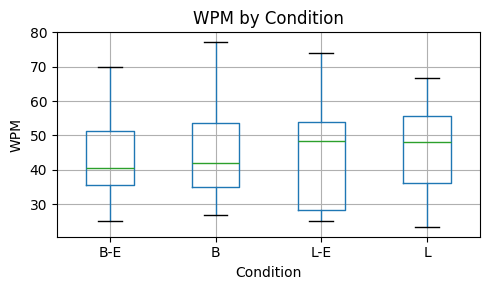

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))
#ax0, ax1, ax2, ax3 = axes.flatten()
ax0=axes
evjoin.boxplot([1,2,3,4], ax=ax0)#[0])
plt.title("WPM by Condition")
ax0.set_xticklabels(['B-E', 'B', 'L-E', 'L'])

ax0.set_ylabel('WPM')
ax0.set_xlabel('Condition')
plt.tight_layout()
plt.show()

In [34]:
statprint(evjoin, [1,2,3,4])

C Mean Std
1 45.09050761335682 14.414126871434101
2 46.43150639325912 14.753988184589042
3 45.682586338980286 15.857927188397367
4 45.45073611288879 13.93565481148998
-----------
ANOVA 0.0192, p=0.9963
-----------


/Users/ako2/Documents/PythonProjects/venvs/py3.9.4/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  res = hypotest_fun_out(*samples, **kwds)


In [35]:
# Typing speed is not statistically significantly different across any condition

In [ ]:
 ###### eye tracking #####

Experiment type 1
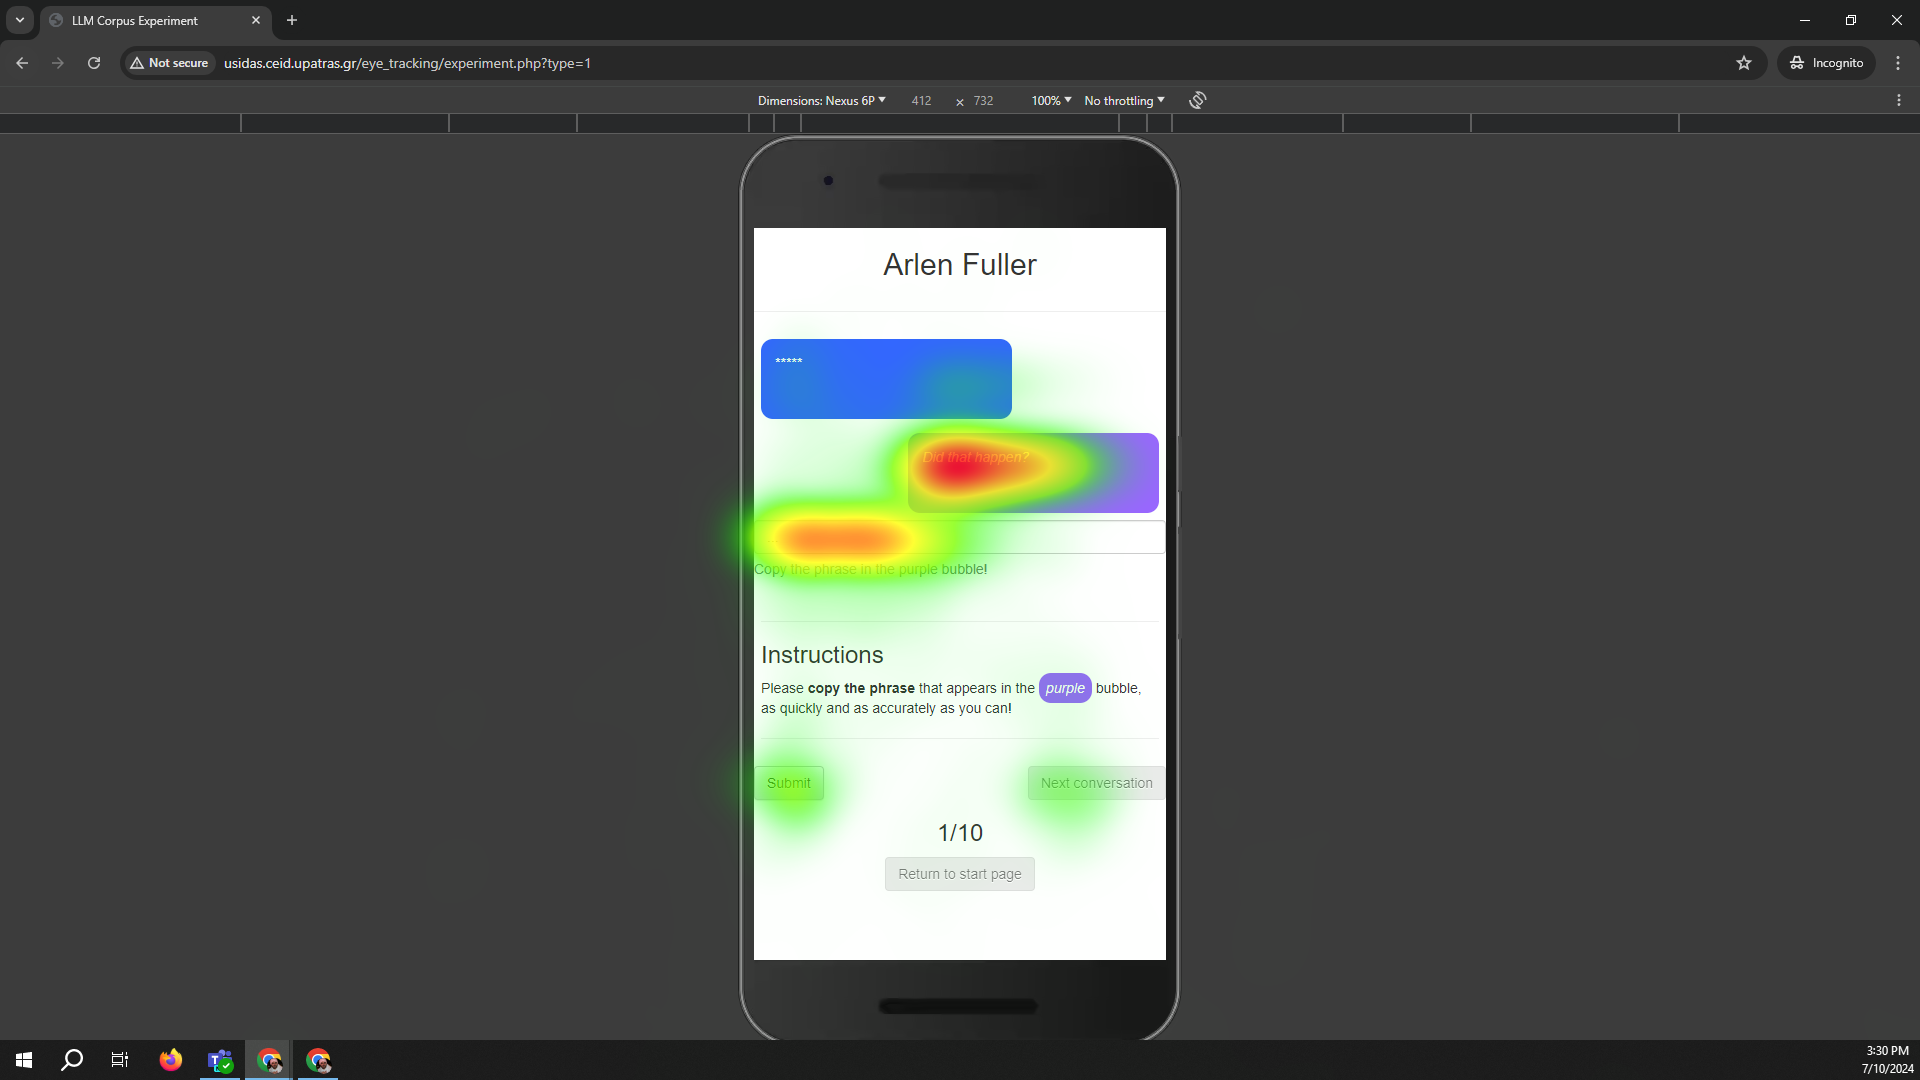

Experiment type 2
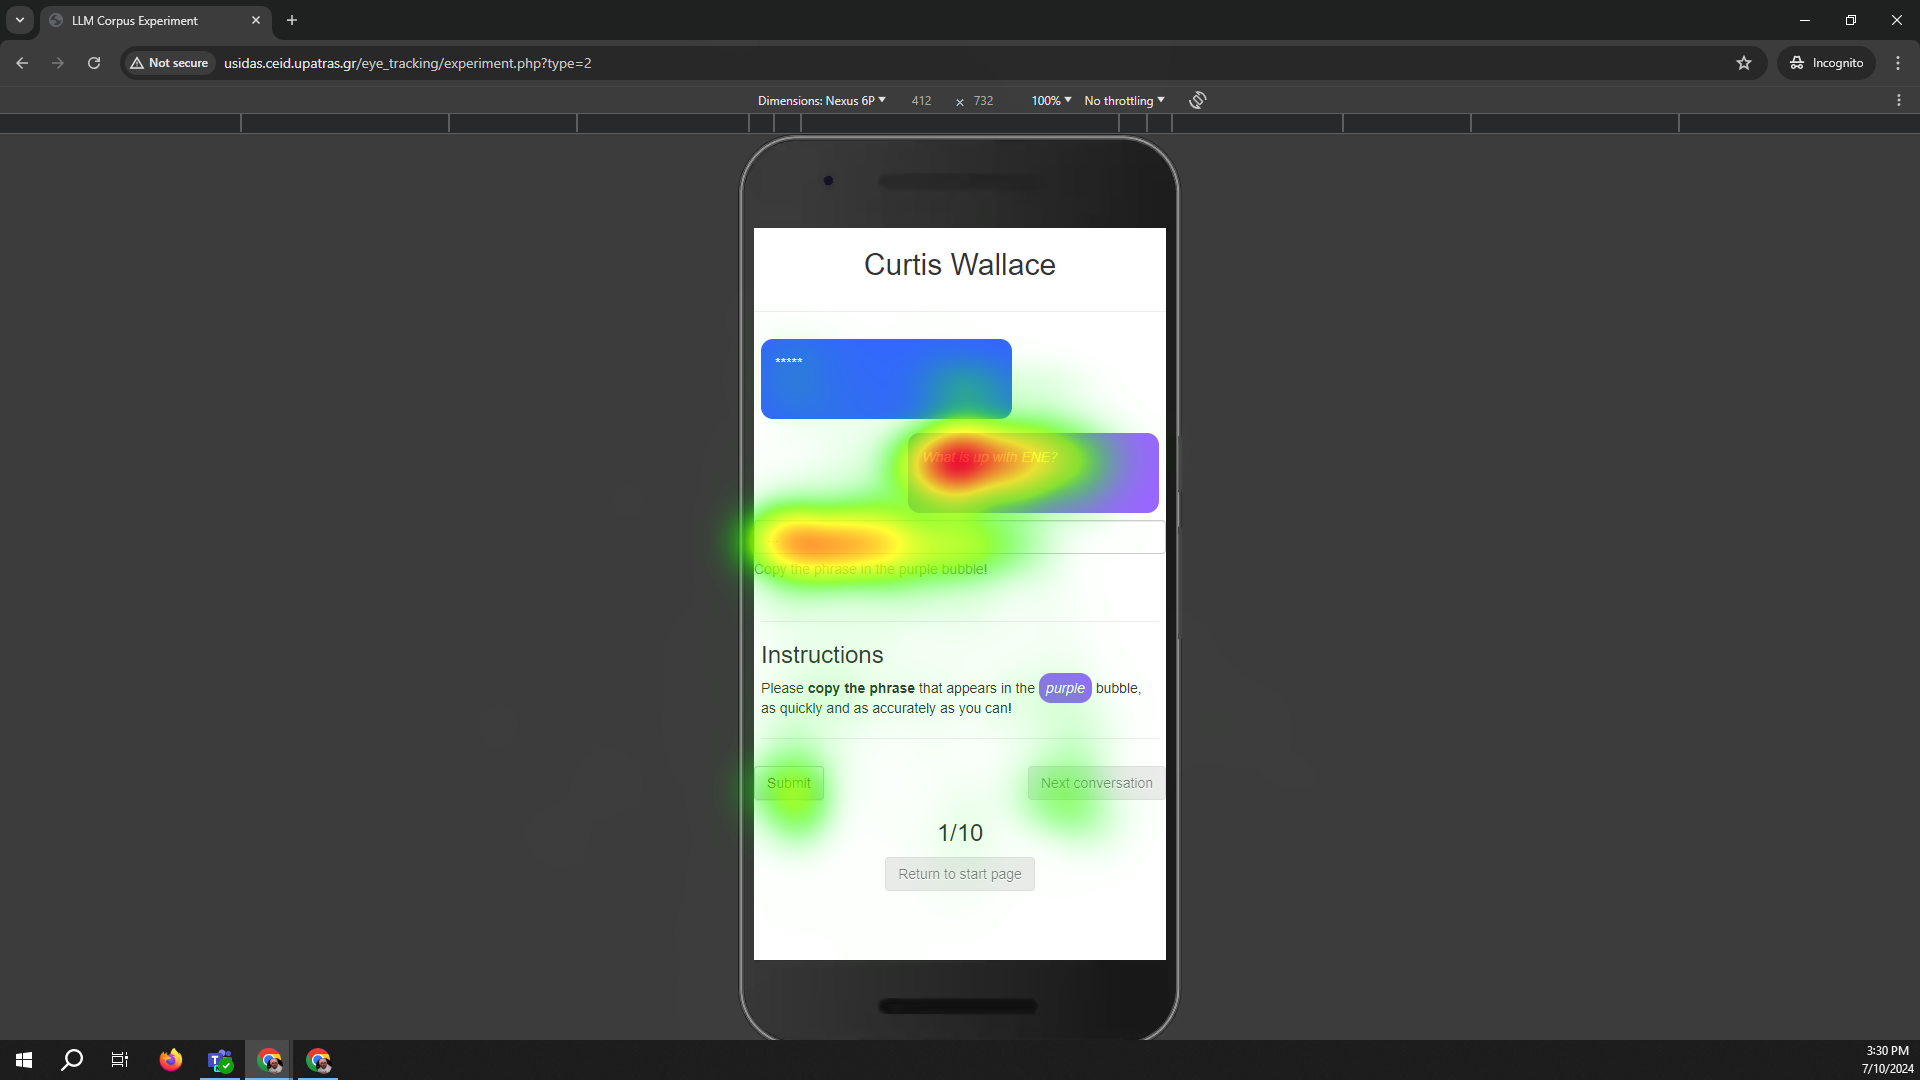


Experiment type 3
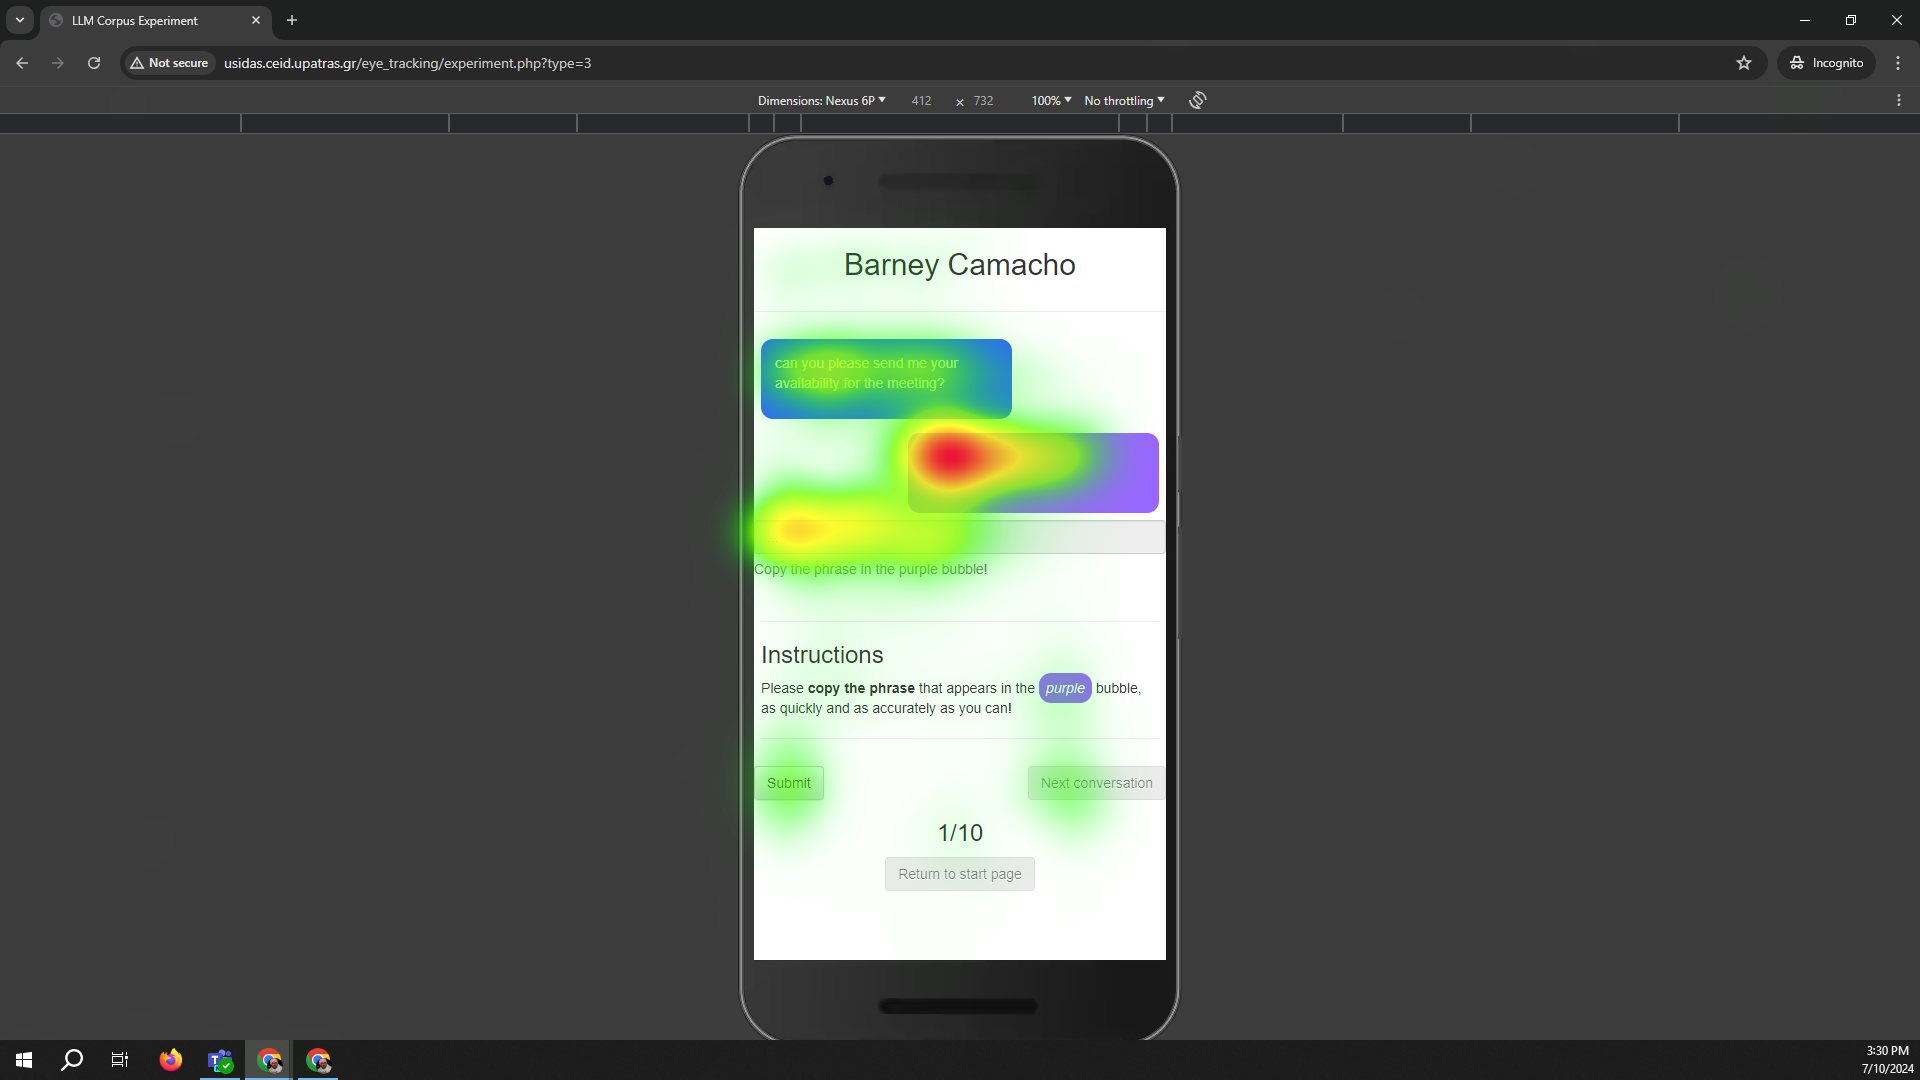

Experiment type 4
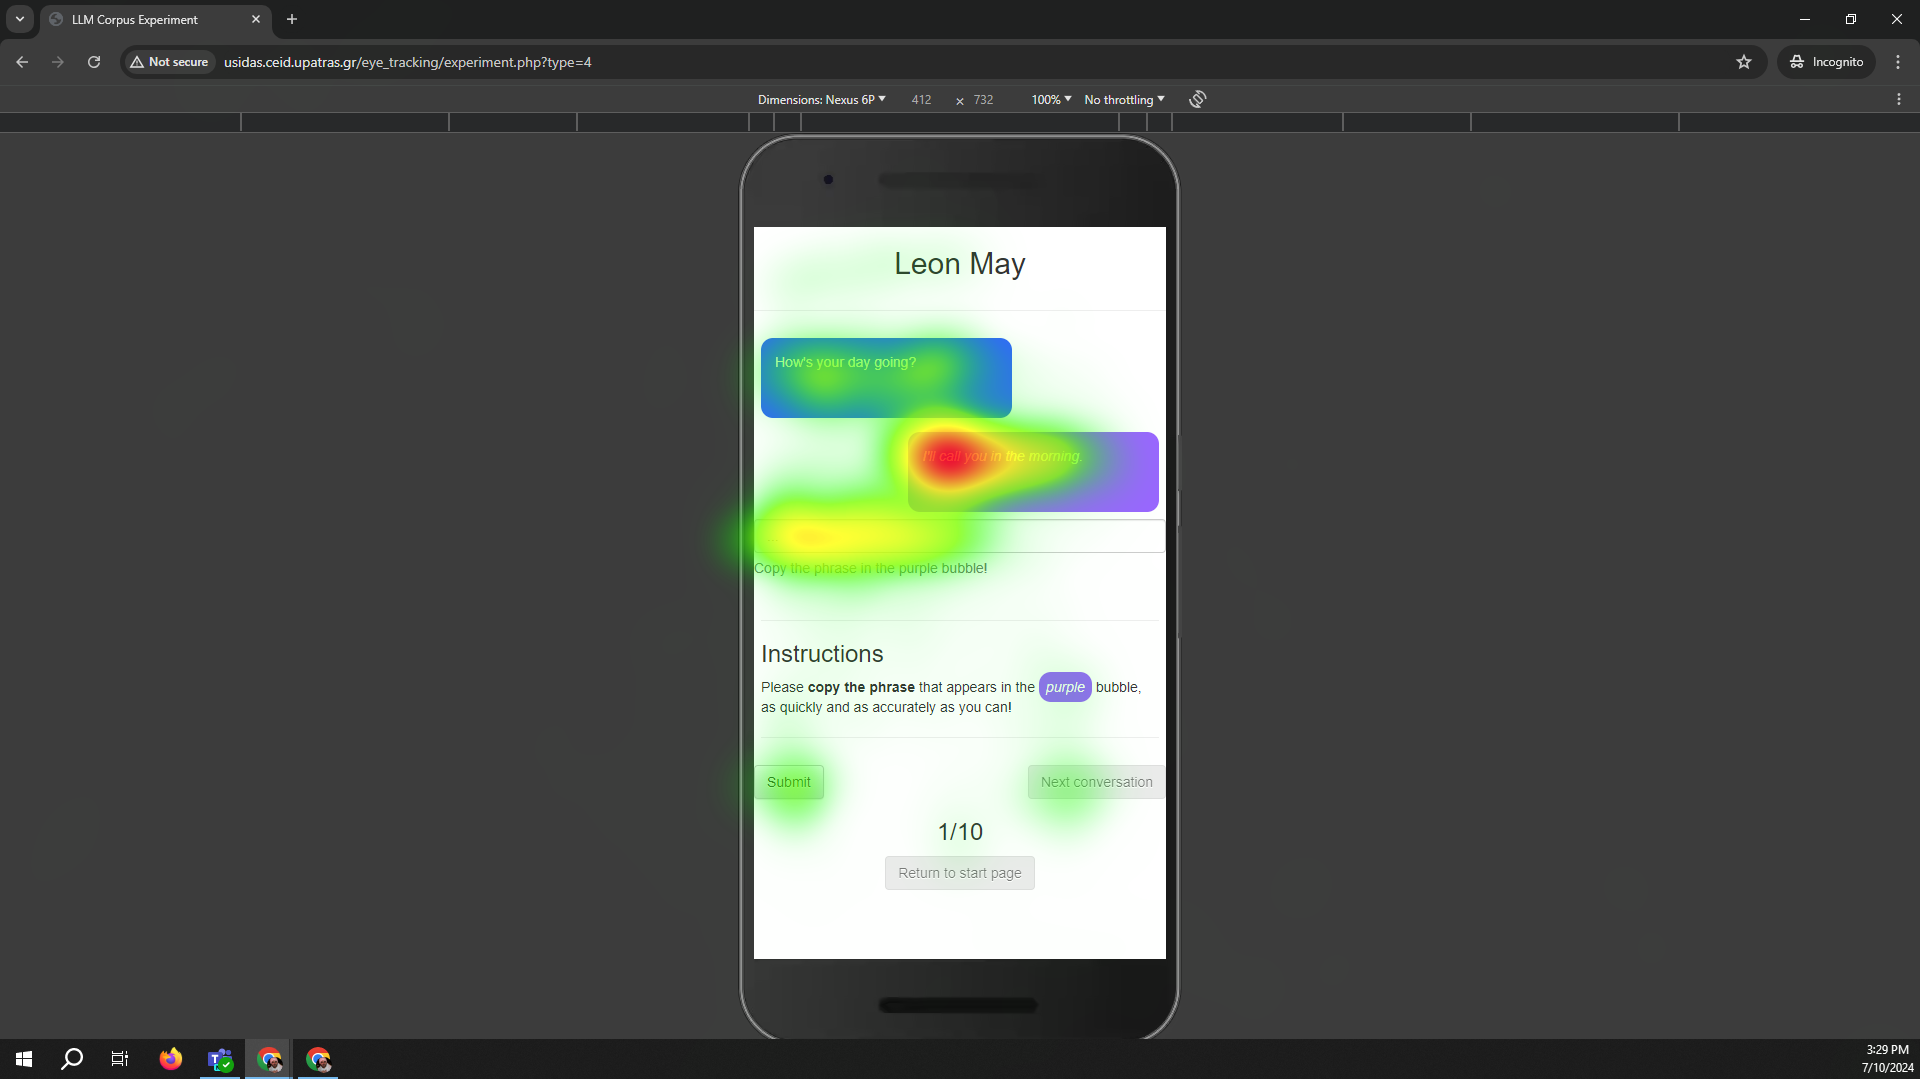

In [ ]:
### Prepare data

In [38]:
eyedf = pd.DataFrame()

In [39]:
fidur = pd.read_excel('eye-tracker-metrics.xlsx',
                      sheet_name = 'Tot Fixation dur incl 0',
                         header = 1, nrows = 52)
fidur.head(5)

,Total duration of fixation in AOI (including zeroes),Participant,Experiment Type,Blue box,Blue box.1,Blue box.2,Blue box.3,Blue box.4,Blue box.5,Blue box.6,...,Purple box.47,Purple box.48,Purple box.49,Purple box.50,Purple box.51,Average,Median,Sum,Total Time of Interest Duration,Total Recording Duration
0,U8T1,User8_ida8cf5ca5e993a,NaN,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.336780,0,35.025105,124.400425,219.651020
1,U11T4,User11_id4800804c0a8bb,NaN,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.804682,0,83.686934,300.230936,410.407005
2,U8T4,User8_ida8cf5ca5e993a,NaN,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.616012,0,64.065229,151.360471,202.259228
3,U2T4,User2__id88d9599e3704f,NaN,0.000000,0.0,0.0,0.0,0.0,0.0,10.0967,...,0.0,0.0,0.0,0.0,0.0,0.537598,0,55.910172,164.410448,223.905952
4,U1T3,User1__id0b3b44e2cef4d,NaN,26.693426,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.735162,0,76.456898,201.708876,394.850400


In [40]:
#extract pid and extype
eyedf['pid']=fidur['Participant'].apply(lambda x: x.replace("__","_").split("_")[1])
eyedf['extype']=fidur['Total duration of fixation in AOI (including zeroes)'].apply(lambda x: x[len(x)-1])
eyedf['extype'] = eyedf["extype"].astype(int)
eyedf.head(5)

,pid,extype
0,ida8cf5ca5e993a,1
1,id4800804c0a8bb,4
2,ida8cf5ca5e993a,4
3,id88d9599e3704f,4
4,id0b3b44e2cef4d,3


In [41]:
bluekeys = []
purplekeys = []
for k in list(fidur.keys()):
    if "Blue" in k:
        bluekeys.append(k)
    if "Purple" in k:
        purplekeys.append(k)
print (bluekeys)

['Blue box', 'Blue box.1', 'Blue box.2', 'Blue box.3', 'Blue box.4', 'Blue box.5', 'Blue box.6', 'Blue box.7', 'Blue box.8', 'Blue box.9', 'Blue box.10', 'Blue box.11', 'Blue box.12', 'Blue box.13', 'Blue box.14', 'Blue box.15', 'Blue box.16', 'Blue box.17', 'Blue box.18', 'Blue box.19', 'Blue box.20', 'Blue box.21', 'Blue box.22', 'Blue box.23', 'Blue box.24', 'Blue box.25', 'Blue box.26', 'Blue box.27', 'Blue box.28', 'Blue box.29', 'Blue box.30', 'Blue box.31', 'Blue box.32', 'Blue box.33', 'Blue box.34', 'Blue box.35', 'Blue box.36', 'Blue box.37', 'Blue box.38', 'Blue box.39', 'Blue box.40', 'Blue box.41', 'Blue box.42', 'Blue box.43', 'Blue box.44', 'Blue box.45', 'Blue box.46', 'Blue box.47', 'Blue box.48', 'Blue box.49', 'Blue box.50', 'Blue box.51']


In [42]:
eyedf['blue_fixdur'] = fidur[bluekeys].sum(axis=1)
eyedf['purple_fixdur'] = fidur[purplekeys].sum(axis=1)
eyedf.head(5)

,pid,extype,blue_fixdur,purple_fixdur
0,ida8cf5ca5e993a,1,0.533334,34.491771
1,id4800804c0a8bb,4,14.013369,69.673565
2,ida8cf5ca5e993a,4,9.008368,55.056861
3,id88d9599e3704f,4,10.096700,45.813472
4,id0b3b44e2cef4d,3,26.693426,49.763472


In [44]:
fidur = pd.read_excel('eye-tracker-metrics.xlsx',
                      sheet_name = 'Fixation count incl 0',
                         header = 1, nrows = 52)
eyedf['blue_totalfix'] = fidur[bluekeys].sum(axis=1)
eyedf['purple_totalfix'] = fidur[purplekeys].sum(axis=1)

fidur = pd.read_excel('eye-tracker-metrics.xlsx',
                      sheet_name = 'Time to first Fixation',
                         header = 1, nrows = 52)
eyedf['blue_timetofix'] = fidur[bluekeys].sum(axis=1)
eyedf['purple_timetofix'] = fidur[purplekeys].sum(axis=1)

fidur = pd.read_excel('eye-tracker-metrics.xlsx',
                      sheet_name = 'Tot Visit dur incl 0',
                         header = 1, nrows = 52)
eyedf['blue_visitdur'] = fidur[bluekeys].sum(axis=1)
eyedf['purple_visitdur'] = fidur[purplekeys].sum(axis=1)

fidur = pd.read_excel('eye-tracker-metrics.xlsx',
                      sheet_name = 'Visit count incl 0',
                         header = 1, nrows = 52)
eyedf['blue_totalvisit'] = fidur[bluekeys].sum(axis=1)
eyedf['purple_totalvisit'] = fidur[purplekeys].sum(axis=1)

eyedf.head(5)

,pid,extype,blue_fixdur,purple_fixdur,blue_totalfix,purple_totalfix,blue_timetofix,purple_timetofix,blue_visitdur,purple_visitdur,blue_totalvisit,purple_totalvisit
0,ida8cf5ca5e993a,1,0.533334,34.491771,3,106,0.425005,1.428341,0.533334,35.831778,3,33
1,id4800804c0a8bb,4,14.013369,69.673565,42,186,0.133333,0.433333,14.470034,81.586926,20,58
2,ida8cf5ca5e993a,4,9.008368,55.056861,38,153,0.000000,2.355005,9.411704,57.473532,21,37
3,id88d9599e3704f,4,10.096700,45.813472,40,157,0.000000,1.710005,11.106701,51.460153,14,46
4,id0b3b44e2cef4d,3,26.693426,49.763472,97,174,0.193334,0.590003,28.666753,62.773503,21,46


In [45]:
### Data ready, now test ####

In [46]:
# Do they spend any time examining the prompt phrase? Fixation duration in blue bubble
testdf=eyedf[['pid','extype','blue_fixdur']].pivot(index='pid', columns ='extype', values='blue_fixdur')
testdf.reset_index(inplace=True)
testdf.head(5)

extype,pid,1,2,3,4
0,id0b3b44e2cef4d,0.383335,0.079999,26.693426,30.493420
1,id0bdef54858cd3,3.043341,4.288349,22.781737,21.758401
2,id15d11dd8fd8aa,0.183333,0.360000,8.790021,17.153370
3,id1d7694116bf3a,0.846669,0.223333,10.650020,8.253355
4,id3d3533f2ad9f7,1.796667,2.370003,47.763465,36.203423


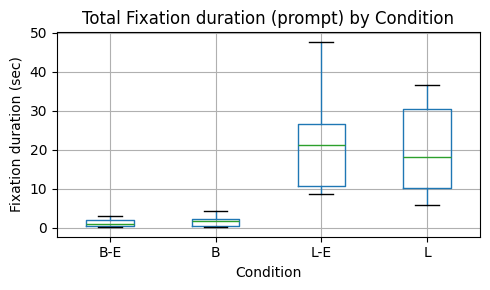

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))
#ax0, ax1, ax2, ax3 = axes.flatten()
ax0=axes
testdf.boxplot([1,2,3,4], ax=ax0)#[0])
plt.title("Total Fixation duration (prompt) by Condition")
ax0.set_xticklabels(['B-E', 'B', 'L-E', 'L'])

ax0.set_ylabel('Fixation duration (sec)')
ax0.set_xlabel('Condition')
plt.tight_layout()
plt.savefig("pngs/total_fix_dur_prompt.png")
plt.show()

In [48]:
statprint(testdf, [1,2,3,4])

C Mean Std
1 1.3420545384615383 0.9765773059707575
2 1.5511580769230768 1.2355367359711504
3 21.391216384615383 11.859602184610004
4 20.466469076923076 10.915992095447933
-----------
ANOVA 25.1127, p=0.0
-----------
T-test (1, 2): -0.6504, p=0.5277
T-test (1, 3): -6.3141, p=0.0 *
T-test (1, 4): -6.422, p=0.0 *
T-test (2, 3): -6.139, p=0.0001 *
T-test (2, 4): -6.2484, p=0.0 *
T-test (3, 4): 0.5946, p=0.5631
bf-adj p: 0.0083

                #    Experiments:
                
                #    1 - no prompt typewriter
                #    2 - no prompt all
                #    3 - prompt typewriter
                #    4 - prompt all
                


/Users/ako2/Documents/PythonProjects/venvs/py3.9.4/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  res = hypotest_fun_out(*samples, **kwds)


In [49]:
# fixation duration in prompt phrase is greater in prompt conditions, both with typewriter (1-3) and without (2-4). 
# Typewriter doesn't have an impact within the same condition group (prompt, no prompt).

In [50]:
# Do they spend any time examining the prompt phrase? Total fixations in blue bubble
testdf=eyedf[['pid','extype','blue_totalfix']].pivot(index='pid', columns ='extype', values='blue_totalfix')
testdf.reset_index(inplace=True)
testdf.head(5)

extype,pid,1,2,3,4
0,id0b3b44e2cef4d,3,1,97,95
1,id0bdef54858cd3,12,16,93,83
2,id15d11dd8fd8aa,1,2,28,70
3,id1d7694116bf3a,6,2,54,42
4,id3d3533f2ad9f7,8,13,184,128


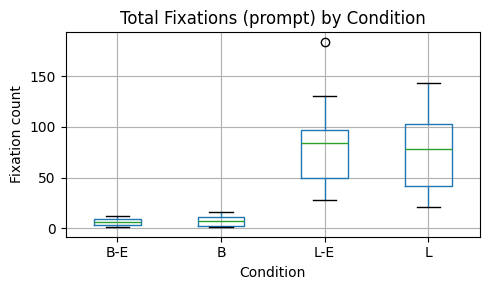

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))
#ax0, ax1, ax2, ax3 = axes.flatten()
ax0=axes
testdf.boxplot([1,2,3,4], ax=ax0)#[0])
plt.title("Total Fixations (prompt) by Condition")
ax0.set_xticklabels(['B-E', 'B', 'L-E', 'L'])

ax0.set_ylabel('Fixation count')
ax0.set_xlabel('Condition')
plt.tight_layout()
plt.savefig("pngs/total_fix_prompt.png")

plt.show()

In [52]:
statprint(testdf, [1,2,3,4])

C Mean Std
1 5.846153846153846 3.804518231571374
2 6.923076923076923 5.040858697707803
3 82.0 44.72694937059759
4 76.23076923076923 38.15790404392831
-----------
ANOVA 26.3092, p=0.0
-----------
T-test (1, 2): -0.7678, p=0.4575
T-test (1, 3): -6.349, p=0.0 *
T-test (1, 4): -6.747, p=0.0 *
T-test (2, 3): -6.3205, p=0.0 *
T-test (2, 4): -6.7138, p=0.0 *
T-test (3, 4): 0.8954, p=0.3882
bf-adj p: 0.0083

                #    Experiments:
                
                #    1 - no prompt typewriter
                #    2 - no prompt all
                #    3 - prompt typewriter
                #    4 - prompt all
                


/Users/ako2/Documents/PythonProjects/venvs/py3.9.4/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  res = hypotest_fun_out(*samples, **kwds)


In [53]:
# fixation count in prompt phrase is greater in prompt conditions, both with typewriter (1-3) and without (2-4). 
# Typewriter doesn't have an impact within the same condition (prompt, no prompt).

In [54]:
# In which condition is the fixation duration more for the response bubble? (reading intensely)
testdf=eyedf[['pid','extype','purple_fixdur']].pivot(index='pid', columns ='extype', values='purple_fixdur')
testdf.reset_index(inplace=True)
testdf.head(5)

extype,pid,1,2,3,4
0,id0b3b44e2cef4d,34.526767,36.126749,49.763472,43.586796
1,id0bdef54858cd3,45.665133,54.440189,46.150157,51.203504
2,id15d11dd8fd8aa,23.928373,21.333346,47.316763,37.680084
3,id1d7694116bf3a,29.610055,32.153373,34.116739,42.013401
4,id3d3533f2ad9f7,59.013449,48.528476,60.608487,72.940189


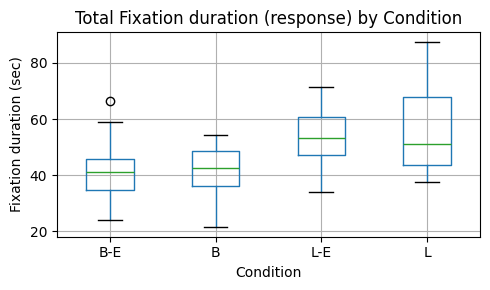

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))
#ax0, ax1, ax2, ax3 = axes.flatten()
ax0=axes
testdf.boxplot([1,2,3,4], ax=ax0)#[0])
plt.title("Total Fixation duration (response) by Condition")
ax0.set_xticklabels(['B-E', 'B', 'L-E', 'L'])

ax0.set_ylabel('Fixation duration (sec)')
ax0.set_xlabel('Condition')
plt.tight_layout()
plt.savefig("pngs/total_fix_dur_response.png")

plt.show()

In [56]:
statprint(testdf, [1,2,3,4])

C Mean Std
1 41.35241792307692 11.52804929384997
2 41.07370153846154 9.51071662736699
3 53.38565223076924 10.70905009777709
4 54.89220692307692 15.36097666716248
-----------
ANOVA 5.0808, p=0.0039
-----------
T-test (1, 2): 0.0998, p=0.9221
T-test (1, 3): -3.4504, p=0.0048 *
T-test (1, 4): -6.2763, p=0.0 *
T-test (2, 3): -4.7034, p=0.0005 *
T-test (2, 4): -3.8045, p=0.0025 *
T-test (3, 4): -0.4222, p=0.6803
bf-adj p: 0.0083

                #    Experiments:
                
                #    1 - no prompt typewriter
                #    2 - no prompt all
                #    3 - prompt typewriter
                #    4 - prompt all
                


/Users/ako2/Documents/PythonProjects/venvs/py3.9.4/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  res = hypotest_fun_out(*samples, **kwds)


In [57]:
# fixation duration in response phrase is greater in prompt conditions, both with typewriter (1-3) and without (2-4). 
# Typewriter doesn't have an impact within the same condition (prompt, no prompt).

In [58]:
# In which condition do they have more fixations on the response phrase?
testdf=eyedf[['pid','extype','purple_totalfix']].pivot(index='pid', columns ='extype', values='purple_totalfix')
testdf.reset_index(inplace=True)
testdf.head(5)

extype,pid,1,2,3,4
0,id0b3b44e2cef4d,105,101,174,105
1,id0bdef54858cd3,151,203,156,162
2,id15d11dd8fd8aa,71,75,124,129
3,id1d7694116bf3a,104,107,141,162
4,id3d3533f2ad9f7,183,166,225,227


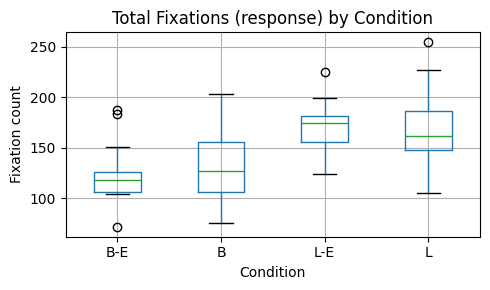

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))
#ax0, ax1, ax2, ax3 = axes.flatten()
ax0=axes
testdf.boxplot([1,2,3,4], ax=ax0)#[0])
plt.title("Total Fixations (response) by Condition")
ax0.set_xticklabels(['B-E', 'B', 'L-E', 'L'])

ax0.set_ylabel('Fixation count')
ax0.set_xlabel('Condition')
plt.tight_layout()
plt.savefig("pngs/total_fix_response.png")
plt.show()

In [60]:
statprint(testdf, [1,2,3,4])

C Mean Std
1 124.23076923076923 32.28300338711236
2 131.3846153846154 35.843498856227896
3 169.53846153846155 27.24767691815024
4 169.30769230769232 40.20651816017028
-----------
ANOVA 6.5008, p=0.0009
-----------
T-test (1, 2): -0.7041, p=0.4948
T-test (1, 3): -5.1826, p=0.0002 *
T-test (1, 4): -6.6458, p=0.0 *
T-test (2, 3): -4.5346, p=0.0007 *
T-test (2, 4): -2.8915, p=0.0135
T-test (3, 4): 0.0212, p=0.9835
bf-adj p: 0.0083

                #    Experiments:
                
                #    1 - no prompt typewriter
                #    2 - no prompt all
                #    3 - prompt typewriter
                #    4 - prompt all
                


/Users/ako2/Documents/PythonProjects/venvs/py3.9.4/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  res = hypotest_fun_out(*samples, **kwds)


In [61]:
# fixation count in response phrase is greater in prompt conditions with typewriter (1-3) but not without (2-4). 
# Typewriter doesn't have an impact within the same condition (prompt, no prompt).

In [62]:
# In which condition do they take longer to fixate on the response phrase?
testdf=eyedf[['pid','extype','purple_timetofix']].pivot(index='pid', columns ='extype', values='purple_timetofix')
testdf.reset_index(inplace=True)
testdf.head(5)

extype,pid,1,2,3,4
0,id0b3b44e2cef4d,0.231668,0.106666,0.590003,4.743346
1,id0bdef54858cd3,0.205000,1.121668,1.151668,1.798337
2,id15d11dd8fd8aa,0.000000,0.116666,0.773335,0.823335
3,id1d7694116bf3a,0.000000,4.853337,0.000000,0.118334
4,id3d3533f2ad9f7,0.000000,0.000000,0.000000,3.003338


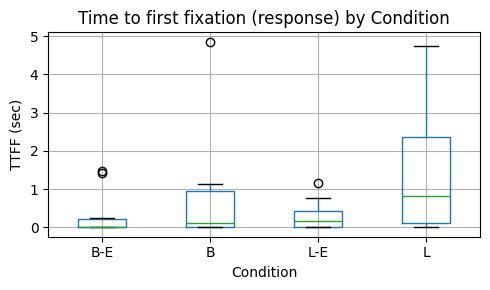

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))
#ax0, ax1, ax2, ax3 = axes.flatten()
ax0=axes
testdf.boxplot([1,2,3,4], ax=ax0)#[0])
plt.title("Time to first fixation (response) by Condition")
ax0.set_xticklabels(['B-E', 'B', 'L-E', 'L'])

ax0.set_ylabel('TTFF (sec)')
ax0.set_xlabel('Condition')
plt.tight_layout()
plt.savefig("pngs/ttff_response.png")
plt.show()

In [64]:
statprint(testdf, [1,2,3,4])

C Mean Std
1 0.28884769230769236 0.5250758255390969
2 0.696411076923077 1.3215920757188695
3 0.28115461538461545 0.3604757915946041
4 1.4185933076923076 1.5526906241486307
-----------
FRIEDMAN 5.9732, p=0.1129
-----------


/Users/ako2/Documents/PythonProjects/venvs/py3.9.4/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  res = hypotest_fun_out(*samples, **kwds)


In [65]:
# Time to first fixation is not statistically significantly different across conditions

In [66]:
# How much time do they spend looking at prompt and response bubbles in each condition?
testdf=eyedf[['pid','extype','blue_fixdur','purple_fixdur']].pivot(index='pid', columns ='extype', values=['blue_fixdur','purple_fixdur'])
testdf.reset_index(inplace=True)
testdf.head(5)

pid blue_fixdur                                  \
extype                            1         2          3          4   
0       id0b3b44e2cef4d    0.383335  0.079999  26.693426  30.493420   
1       id0bdef54858cd3    3.043341  4.288349  22.781737  21.758401   
2       id15d11dd8fd8aa    0.183333  0.360000   8.790021  17.153370   
3       id1d7694116bf3a    0.846669  0.223333  10.650020   8.253355   
4       id3d3533f2ad9f7    1.796667  2.370003  47.763465  36.203423   

       purple_fixdur                                   
extype             1          2          3          4  
0          34.526767  36.126749  49.763472  43.586796  
1          45.665133  54.440189  46.150157  51.203504  
2          23.928373  21.333346  47.316763  37.680084  
3          29.610055  32.153373  34.116739  42.013401  
4          59.013449  48.528476  60.608487  72.940189

In [67]:
testdf.keys()

MultiIndex([(          'pid', ''),
            (  'blue_fixdur',  1),
            (  'blue_fixdur',  2),
            (  'blue_fixdur',  3),
            (  'blue_fixdur',  4),
            ('purple_fixdur',  1),
            ('purple_fixdur',  2),
            ('purple_fixdur',  3),
            ('purple_fixdur',  4)],
           names=[None, 'extype'])

In [68]:
testdf.columns = [column[0]+"_"+str(column[1]) for column in testdf.columns.to_flat_index()]
testdf.head(5)

,pid_,blue_fixdur_1,blue_fixdur_2,blue_fixdur_3,blue_fixdur_4,purple_fixdur_1,purple_fixdur_2,purple_fixdur_3,purple_fixdur_4
0,id0b3b44e2cef4d,0.383335,0.079999,26.693426,30.493420,34.526767,36.126749,49.763472,43.586796
1,id0bdef54858cd3,3.043341,4.288349,22.781737,21.758401,45.665133,54.440189,46.150157,51.203504
2,id15d11dd8fd8aa,0.183333,0.360000,8.790021,17.153370,23.928373,21.333346,47.316763,37.680084
3,id1d7694116bf3a,0.846669,0.223333,10.650020,8.253355,29.610055,32.153373,34.116739,42.013401
4,id3d3533f2ad9f7,1.796667,2.370003,47.763465,36.203423,59.013449,48.528476,60.608487,72.940189


In [69]:
for i in range(1,5):
    testdf['prompt_'+str(i)] = testdf['blue_fixdur_'+str(i)] / (testdf['blue_fixdur_'+str(i)] +testdf['purple_fixdur_'+str(i)])
testdf.head(5)

,pid_,blue_fixdur_1,blue_fixdur_2,blue_fixdur_3,blue_fixdur_4,purple_fixdur_1,purple_fixdur_2,purple_fixdur_3,purple_fixdur_4,prompt_1,prompt_2,prompt_3,prompt_4
0,id0b3b44e2cef4d,0.383335,0.079999,26.693426,30.493420,34.526767,36.126749,49.763472,43.586796,0.010981,0.002210,0.349130,0.411627
1,id0bdef54858cd3,3.043341,4.288349,22.781737,21.758401,45.665133,54.440189,46.150157,51.203504,0.062481,0.073020,0.330496,0.298216
2,id15d11dd8fd8aa,0.183333,0.360000,8.790021,17.153370,23.928373,21.333346,47.316763,37.680084,0.007603,0.016595,0.156666,0.312827
3,id1d7694116bf3a,0.846669,0.223333,10.650020,8.253355,29.610055,32.153373,34.116739,42.013401,0.027799,0.006898,0.237900,0.164191
4,id3d3533f2ad9f7,1.796667,2.370003,47.763465,36.203423,59.013449,48.528476,60.608487,72.940189,0.029546,0.046563,0.440736,0.331704


In [70]:
keys = list(testdf.keys())[9:]
print(keys)

['prompt_1', 'prompt_2', 'prompt_3', 'prompt_4']


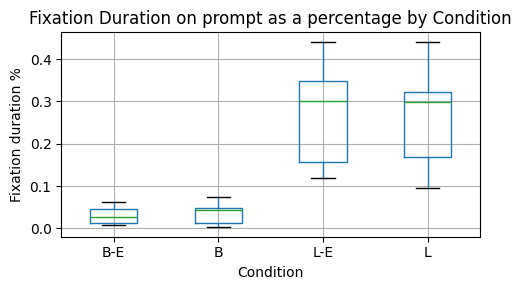

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))
#ax0, ax1, ax2, ax3 = axes.flatten()
ax0=axes
testdf.boxplot(keys, ax=ax0)#[0])
plt.title("Fixation Duration on prompt as a percentage by Condition")
ax0.set_xticklabels(['B-E', 'B', 'L-E', 'L'])

ax0.set_ylabel('Fixation duration %')
ax0.set_xlabel('Condition')
plt.tight_layout()
plt.savefig("pngs/fix_dur_prompt_pct.png")

plt.show()

In [72]:
statprint(testdf, keys)

C Mean Std
prompt_1 0.029462706757432698 0.018450065263631767
prompt_2 0.033874693231677064 0.022875340551094015
prompt_3 0.2752597312460642 0.10885468322186515
prompt_4 0.26293439435492977 0.107152300946614
-----------
ANOVA 40.4471, p=0.0
-----------
T-test (prompt_1, prompt_2): -0.6928, p=0.5016
T-test (prompt_1, prompt_3): -8.5089, p=0.0 *
T-test (prompt_1, prompt_4): -7.7015, p=0.0 *
T-test (prompt_2, prompt_3): -8.1943, p=0.0 *
T-test (prompt_2, prompt_4): -7.5474, p=0.0 *
T-test (prompt_3, prompt_4): 0.5551, p=0.589
bf-adj p: 0.0083

                #    Experiments:
                
                #    1 - no prompt typewriter
                #    2 - no prompt all
                #    3 - prompt typewriter
                #    4 - prompt all
                


/Users/ako2/Documents/PythonProjects/venvs/py3.9.4/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  res = hypotest_fun_out(*samples, **kwds)


In [73]:
# Users spend about 30% of their attention on the prompt bubble part of the stimulus area, when a prompt appears.
# Compared to 3% when the prompt doesn't appear.
# The difference is not statistically significant in the prompt appearance case, for the typewriter effect.